In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import random
import re 
import datetime

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split
import json
import scipy.sparse as sparse
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

D:\Program Files (x86)\Anaconda\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
submission = pd.read_csv('Data/sample_submission.csv')

D:\Program Files (x86)\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\Program Files (x86)\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
with open('Data/meta_Grocery_and_Gourmet_Food.json') as f:
    meta_list = []
    for line in f.readlines():
        meta_list.append(json.loads(line))
        
meta = pd.DataFrame(meta_list)

###  Объединяем датасеты

In [4]:
test['sample']=0
test['rating']=0
train['sample']=1

Data = test.append(train, sort=False).reset_index(drop=True) # объединяем

### В полученных датасетах (meta and train) есть 1 общий столбец, asin по нему мы сделаем объединение 

In [5]:
data = Data.merge(meta, on='asin')

## Проверим данные на дубликат

In [6]:
# отбрасываем неуникальные строки
df_dedupped = data.drop_duplicates(subset=['reviewText','unixReviewTime','userid','Id'], keep='first')
# В данном случае я отбрасываю строку в которой текст отзыва, время когда он был сделан и Id пользователя дублируется в датасете

# сравниваем формы старого и нового наборов
print('Исходный датасет: ',data.shape)
print('Чистый датасет: ',df_dedupped.shape)

Исходный датасет:  (1168686, 32)
Чистый датасет:  (1035412, 32)


In [7]:
df=df_dedupped

# 1)  EDA

test.csv - набор данных, для которого вы должны сделать предсказания. У каждого набора userid, itemid есть свой id, для которого вы должны сделать предсказание.

- overall  - рейтинг, который поставил пользователь
- verified - был ли отзыв верифицирован
- reviewTime - когда был отзыв написан
- asin - уникальный идентификатор товара Amazon
- reviewerName - имя пользователя
- reviewText - текст отзыва
- summary - сжатый отзыв
- unixReviewTime - время отзыва
- vote - количество голосований за отзыв
- style - метаданные
- image_x - изображение продукта
- userid - id пользователя
- itemid - id товара
- rating - рейтинг
- category - категории товаров 
- description - описание
- title - название
- brand - бренд
- rank -
- also_view - также посмотреть
- main_cat - главная категория
- price - цена 
- also_buy - также купить
- image_y - изображение продукта
- date - дата
- feature - пустой столбец
- details - детали
- similar_item - похожий предмет
- tech1 - пустой столбец
- fit - пустой столбец
- id - id для предсказания


# Количество пустых значений

In [8]:
NaN_Sum = lambda col: col.isnull().sum()  # Функция для определения количества нулевых знчений  
columns = list(df.columns)
for col in columns:
    print("Количество пустых значений", col, NaN_Sum(df[col]), sep=' ')

Количество пустых значений verified 0
Количество пустых значений reviewTime 0
Количество пустых значений asin 0
Количество пустых значений reviewerName 176
Количество пустых значений unixReviewTime 0
Количество пустых значений vote 886072
Количество пустых значений style 499163
Количество пустых значений image_x 1026377
Количество пустых значений userid 0
Количество пустых значений itemid 0
Количество пустых значений Id 749447
Количество пустых значений sample 0
Количество пустых значений rating 0
Количество пустых значений overall 285965
Количество пустых значений reviewText 286098
Количество пустых значений summary 286103
Количество пустых значений category 0
Количество пустых значений description 90796
Количество пустых значений title 0
Количество пустых значений brand 7923
Количество пустых значений rank 43769
Количество пустых значений also_view 474500
Количество пустых значений main_cat 1250
Количество пустых значений price 316761
Количество пустых значений also_buy 152434
Количе

В столбцах vote, style, image_x, image_y, also_view, image_y, date,feature, similar_item, tech1, fit слишком много пропусков, поэтому мы эти столбцы просто удалим

In [9]:
df=df.drop(['title','summary','reviewText','overall','reviewTime','vote', 'style', 'image_x', 'image_y', 'also_view', 'image_y', 'date','feature', 'similar_item', 'tech1', 'fit'],axis=1)

### Заменим пропуски на случайные знaчения из списка возможных значений

In [10]:
new_data=df

In [11]:
new_data['price']=new_data['price'].fillna(new_data['price'][random.randint(0,len(list(new_data['price'].unique()))-1)])

In [12]:
new_data['main_cat']=new_data['main_cat'].fillna('other')

# Введем разделение по переменным

Но напишем для этого функцию которая выдает 3 списка 
- Бинарные переменные 
- Категориальные переменные 
- Числовые переменные 

In [13]:
BIN=['verified']
CAT=['asin','reviewerName','userid','itemid','Id','reviewText','summary','category','description','title','brand','rank','main_cat',
    'also_buy','details']
NUM=['sample','rating','overall','price']
TIME=['reviewTime']

In [14]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143860 entries, 0 to 1143859
Data columns (total 16 columns):
verified          1143860 non-null bool
reviewTime        1143860 non-null object
asin              1143860 non-null object
reviewerName      1143637 non-null object
unixReviewTime    1143860 non-null int64
vote              158202 non-null object
style             592086 non-null object
image             9510 non-null object
userid            1143860 non-null int64
itemid            1143860 non-null int64
Id                285965 non-null float64
sample            1143860 non-null int64
rating            1143860 non-null float64
overall           857895 non-null float64
reviewText        857616 non-null object
summary           857725 non-null object
dtypes: bool(1), float64(3), int64(4), object(8)
memory usage: 132.0+ MB


In [15]:
def eng1(Data):
    pattern=re.compile('\d\d')
    a=pattern.findall(Data['price'])
    return int(a[0])
    

new_data['price']= new_data.apply(lambda new_data: eng1(new_data),axis=1)

In [16]:
print('Бинарные переменные: ',BIN)
print('Категориальные переменные',CAT)
print('Числовые переменные',NUM)

Бинарные переменные:  ['verified']
Категориальные переменные ['asin', 'reviewerName', 'userid', 'itemid', 'Id', 'reviewText', 'summary', 'category', 'description', 'title', 'brand', 'rank', 'main_cat', 'also_buy', 'details']
Числовые переменные ['sample', 'rating', 'overall', 'price']


# Поиск и фильтрация выбросов
Проверим на выбросы только те столбцы которые содержат численную информацию

#### Напишем функцию по поиску выбросов 

In [17]:
def outliers_iqr(data,num_columns,n):
    median = data[num_columns[n]].median()
    IQR = data[num_columns[n]].quantile(0.75) - data[num_columns[n]].quantile(0.25)
    perc25 = data[num_columns[n]].quantile(0.25)
    perc75 = data[num_columns[n]].quantile(0.75)
    print(num_columns[n], '25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
          , "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5 * IQR, l=perc75 + 1.5 * IQR))
    quartile_1, quartile_3 = np.percentile(data[num_columns[n]], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((data[num_columns[n]] > upper_bound) | (data[num_columns[n]] < lower_bound))[0]

sample 25-й перцентиль: 0.0, 75-й перцентиль: 1.0, IQR: 1.0,  Границы выбросов: [-1.5, 2.5].
Количество выбросов sample : 0


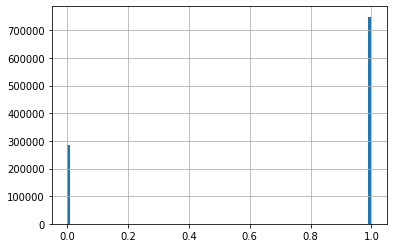

In [18]:
new_data[NUM[0]].hist(bins=100)
print('Количество выбросов',NUM[0],':',len(outliers_iqr(new_data,NUM,0)))

rating 25-й перцентиль: 0.0, 75-й перцентиль: 1.0, IQR: 1.0,  Границы выбросов: [-1.5, 2.5].
Количество выбросов rating : 0


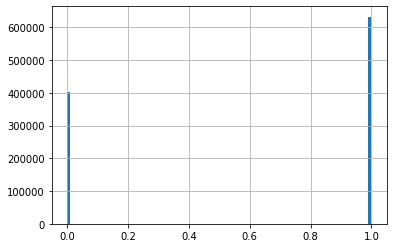

In [19]:
new_data[NUM[1]].hist(bins=100)
print('Количество выбросов',NUM[1],':',len(outliers_iqr(new_data,NUM,1)))

price 25-й перцентиль: 17.0, 75-й перцентиль: 30.0, IQR: 13.0,  Границы выбросов: [-2.5, 49.5].
Количество выбросов price : 104990


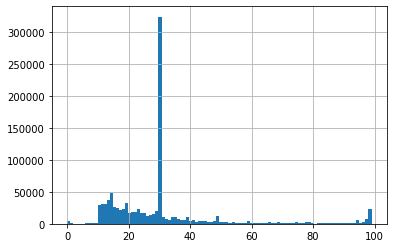

In [20]:
new_data[NUM[3]].hist(bins=100)
print('Количество выбросов',NUM[3],':',len(outliers_iqr(new_data,NUM,3)))

#### Статистический анализ численных параметров показывает, что явных выбросов в данных нет

### Корреляционный анализ

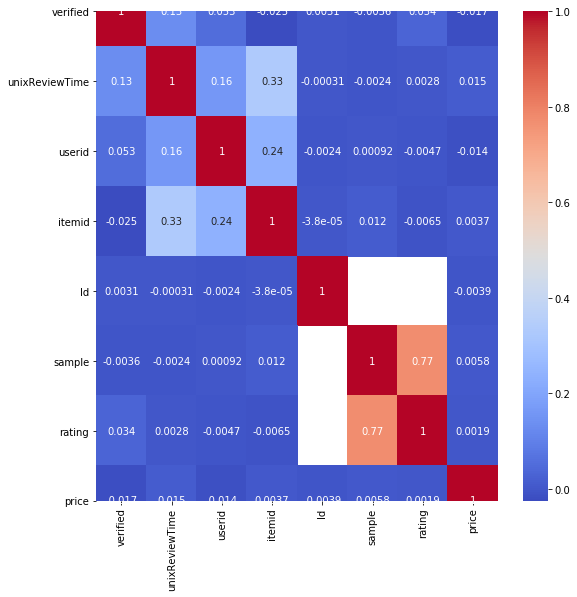

In [21]:
correlation = new_data.corr()
plt.figure(figsize=(9, 9))
sns.heatmap(correlation,annot=True,cmap='coolwarm')

# Проведем анализ всех признаков по итоговому экзамену

### Преобразуем бинарный признак в численный 

In [22]:
label_encoder = LabelEncoder()

In [23]:
new_data['verified'] = label_encoder.fit_transform(new_data['verified'])

# Время unixReviewTime

In [24]:
def time(Data,col):
    value = datetime.datetime.fromtimestamp(Data[col])
    return value.strftime('%Y-%m-%d')

In [25]:
new_data['unixReviewTime']= new_data.apply(lambda new_data: time(new_data,'unixReviewTime'),axis=1)

In [26]:
train_Data = new_data.query('sample == 1').drop(['sample','Id'], axis=1)
test_Data = new_data.query('sample == 0').drop(['sample'], axis=1)

# 3) Model

In [27]:
ratings_coo = sparse.coo_matrix((train_Data['rating'].astype(int),
                                 (train_Data['userid'],
                                  train_Data['itemid'])))

In [28]:
NUM_THREADS = 1 #число потоков
NUM_COMPONENTS = 30 #число параметров вектора 
NUM_EPOCHS = 1 #число эпох обучения

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [29]:
preds = model.predict(test_Data.userid.values,
                      test_Data.itemid.values)

In [30]:
sklearn.metrics.roc_auc_score(test_Data.rating,preds)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [31]:
preds = model.predict(test.userid.values,
                      test.itemid.values)

In [32]:
preds.min(), preds.max()

(-1.0602611303329468, 4.013859272003174)

In [33]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

In [34]:
normalized_preds.min(), normalized_preds.max()

(0.0, 1.0)

In [35]:
submission['rating']= normalized_preds

In [36]:
submission.to_csv('submission_log.csv', index=False)